In [1]:
from sklearn import svm
from sklearn import datasets
import pandas as pd
import pickle
import logging
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Few abnormal findings arise from data type checking on columns `SeniorCitizen` and `TotalCharges`. `SeniorCitizen` contains only 0 and 1, pandas interpretes this as a column with integers while `TotalCharges` is inferred as object, opposite to our expectation of having numeric type. The reason is that in some cases this column contains a space (“ ”) to represent a missing value. When coming across nonnumeric characters, Pandas has no other option but to declare the column “object.”

It is possible to forcefully change the format to numeric, as long as `errors='coerce'` is specified to replace all nonnumeric values with NaN.

In [5]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


Filling up missing values follows the same as the previous chapter

In [6]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

We also want to have columns to be more consistent formatwise. So string replacement is applied as shown below.

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [8]:
df.churn = (df.churn == 'yes').astype(int)

In [9]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


## Data Splitting

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

In [12]:
y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

## EDA

In [13]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [14]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

Check the proportion of churned users among all customers. For that, we need to divide the number of customers who churned by the total number of customers.

In [15]:
global_mean = df_train_full.churn.mean()
round(global_mean, 3)

0.27

Approximately 27% of the customers stopped using our services, and the rest remained as customers.

The proportion of churned customer is three times as many as those keep using the service and since the churn rate in our data is 0.27, it is a strong indicator of class imbalance.

Let's divide column to numerical and categorical lists.

In [16]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [17]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature Importance

### Categorical

In [18]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.277
gender == male:   0.263


Comparing to the global mean, difference between the group rates for both females and males is quite small, indicating that knowing the gender of the customer doesn’t help us identify whether they will churn.

Below we calculate risk factor per each group.

In [19]:
female_mean / global_mean

1.0253955354648652

In [20]:
male_mean / global_mean

0.9749802969838747

Switch observation to feature partner. Check the group churn rate using the same method as did feature gender.

In [21]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print('partner == yes:', round(partner_yes, 3))

partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print('partner == no :', round(partner_no, 3))

partner == yes: 0.205
partner == no : 0.33


The churn rate for people with a partner is significantly less than the rate for the ones without a partner—20.5% versus 33%—which indicates that the partner variable is useful for predicting churn.

In [22]:
partner_yes / global_mean

0.7594724924338315

In [23]:
partner_no / global_mean

1.2216593879412643

 Let’s now do this for all the categorical variables.

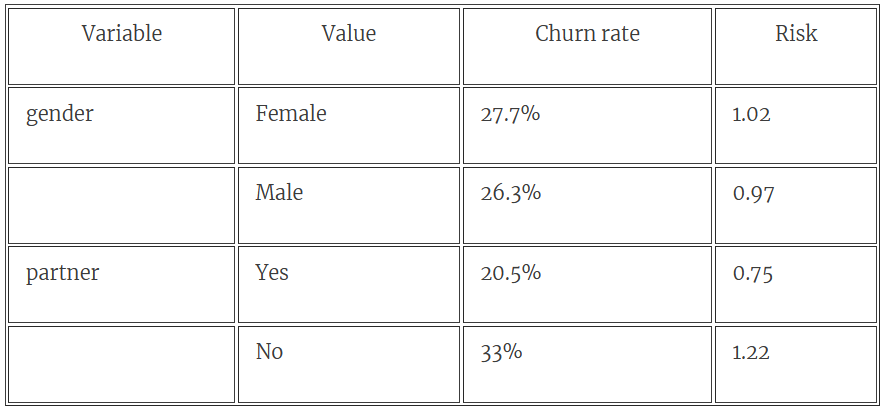

In [24]:
df_group = df_train_full.groupby(by='gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean
df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [25]:
from IPython.display import display

In [26]:
global_mean = df_train_full.churn.mean()

for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


From group risk factor, we learn that:

   - For gender, there is not much difference between females and males. Both means are approximately the same, and for both groups the risks are close to 1.
   - Senior citizens tend to churn more than nonseniors: the risk of churning is 1.53 for seniors and 0.89 for nonseniors.
   - People with a partner churn less than people with no partner. The risks are 0.75 and 1.22, respectively.
   - People who use phone service are not at risk of churning: the risk is close to 1, and there’s almost no difference with the global churn rate. People who don’t use phone service are even less likely to churn: the risk is below 1, and the difference with the global churn rate is negative.


## Mutual Information

To support finding feature importance, measuring dependency between categorical variable and target will give important signal: dependent on target will reveal information on value of one variable about another while variable which is completely independent to the target is safely removed from the dataset. The higher the degree of dependency, the more useful a feature is. It tells how much information we learn about one variable if we learn the value of the other variable.

In [27]:
from sklearn.metrics import mutual_info_score
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)
df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


### Correlation Coefficient

Used for measuring associative degree between numerical feature with binary target.

In [28]:
df_train_full[numerical].corrwith(df_train_full.churn).to_frame('correlation')

,correlation
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [29]:
df_train_full.groupby(by='churn')[numerical].mean()

,tenure,monthlycharges,totalcharges
churn,,,
0,37.531972,61.176477,2548.021627
1,18.070348,74.521203,1545.689415


After doing initial exploratory data analysis, identifying important features, and getting some insights into the problem, we are ready to do the next step: feature engineering and model training.

## Feature Engineering: One-hot Encoding

In [30]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train[categorical + numerical].to_dict(orient='records')
train_dict[0]

{'gender': 'male',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 71,
 'monthlycharges': 86.1,
 'totalcharges': 6045.9}

In [31]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [32]:
X_train = dv.transform(train_dict)

In [33]:
dv.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

## Training Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [35]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [36]:
model.predict_proba(X_val)

array([[0.76508893, 0.23491107],
       [0.7311339 , 0.2688661 ],
       [0.6805482 , 0.3194518 ],
       ...,
       [0.94274725, 0.05725275],
       [0.38476961, 0.61523039],
       [0.93872737, 0.06127263]])

In [37]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred > 0.5

In [38]:
(y_val == churn).mean()

0.8016129032258065

Accuracy of this model is nearly 80%. Quite reliable to use against test set.

### Model Interpretation

Logistic regression returns bias from `model.intercept_[0]` and weight vectors from `model.coef_[0]`. 

In [39]:
# Bias term
model.intercept_[0]

-0.12198863589816404

You can pair weight vectors with feature names from `DictVectorizer` with `dict` and `zip`.

In [40]:
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


To help us understand what exactly happen when applying logistic regression, we will use two numerical variables and one categorical variable and train a smaller version of the model.

In [41]:
# Choosing three variables for generating a simpler model
subset = ['contract', 'tenure', 'totalcharges']

## Take the very same step as did on full dataset
train_dict_small = df_train[subset].to_dict(orient='records')

## Prevent overwriting on DictVectorizer by adding prefix `small`
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

## Transform small train dictionary
X_small_train = dv_small.transform(train_dict_small)

dv_small.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'tenure',
 'totalcharges']

In [42]:
## Prevent overwriting on model by adding prefix `small`
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [43]:
model_small.intercept_[0]

-0.577229912199359

In [44]:
dict(zip(dv_small.get_feature_names(), model_small.coef_[0].round(3)))

{'contract=month-to-month': 0.866,
 'contract=one_year': -0.327,
 'contract=two_year': -1.117,
 'tenure': -0.094,
 'totalcharges': 0.001}

We will mention about more interpretation detail from his book `Machine Learning Bookcamp`. It's no problem about the difference of weight and bias from above to the values given from the book.

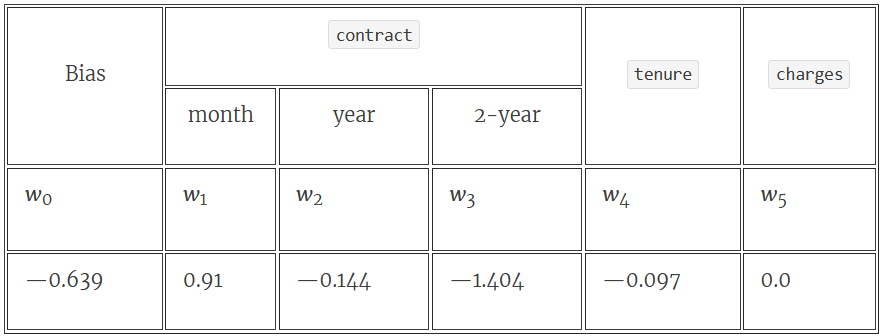

Since the proportion on target churn is ,in majority, non-churned by a large difference in counts, the churn probability on average is relatively low. Make sense.

```
'contract=month-to-month': 0.91,
 'contract=one_year': -0.144,
 'contract=two_year': -1.404.
```

Let's take an example on client choosing month-to-month contract. In one-hot encoding standpoint, its vector representation of would be [1,0,0] (1 for month-to-month while 0 for one and two year). Multiplying by dot product on this vector and weights results in:

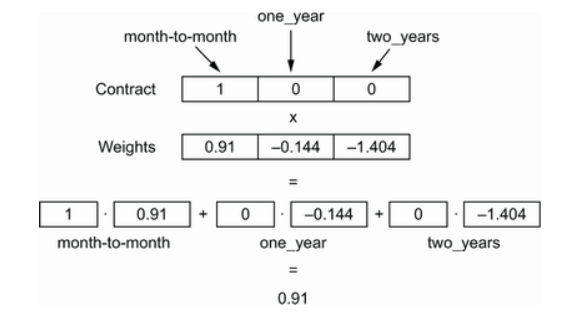

Interpretation of the sign of weights for one-hot encoded features follows the same intuition as the bias term (positive means more chance to churn and vice versa).  

In [53]:
print(1 / (1 + np.exp(-0.91)))
print(1 / (1 + np.exp(0.144)))
print(1 / (1 + np.exp(1.404)))

0.7130001627522816
0.4640620792755912
0.1971821390017604


Magnitude of weights matters: contract `two-year` with value -1.404 is greather than `one-year` (-0.144), making the former having a stronger indicator of not churning than the latter.

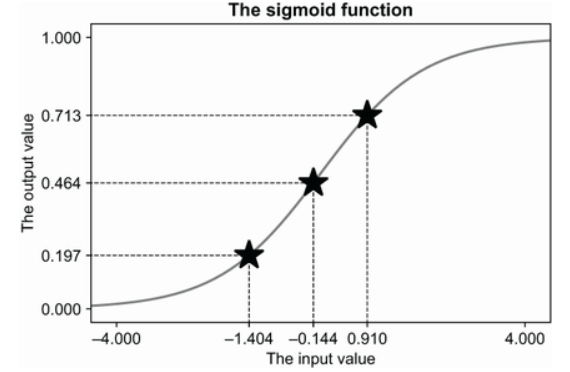

Now, shifting our observation to numerical variables, we find that:
   - `tenure` feature indicate no churn as longer stay means less likely to churn. Even more, their correlation with `churn` is -0.35. 
   - `totalcharges` feature has zero weight: not much of significance to the model.
   
Let's do a small exercise: imagine we are about to predict a customer with month-to-month contract spent a year with the service and paid 1000.
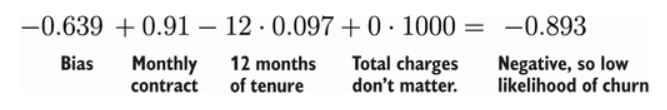

Step-by-step calculation:
   - Start with a baseline, bias, with a value of -0.639.
   - Add bias with weight of month-to-month feature (0.271) and this will come out to 0.271. Know that a person with this contract has a higher chance of churning.
   - Consider `tenure` variable. Multiply how long he has stayed so far with its weight. The value would be 0.271 - 12*(0.091) = -0.893.
   - Add the result to amount paid `totalcharges`. We know that this feature won't do anything. Stays the same, -0.893.
   - Compute this value to the sigmoid function and the score will be near 0.29
   - treat this as the probability that this customer will churn.

In [54]:
print(1 / (1 + np.exp(0.893)))

0.2904911209356156


Take a second customer with a yearly contract having been stayed for two years and amount 2000.

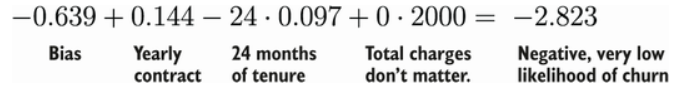

Using the sigmoid function, the output would be around 0.056.

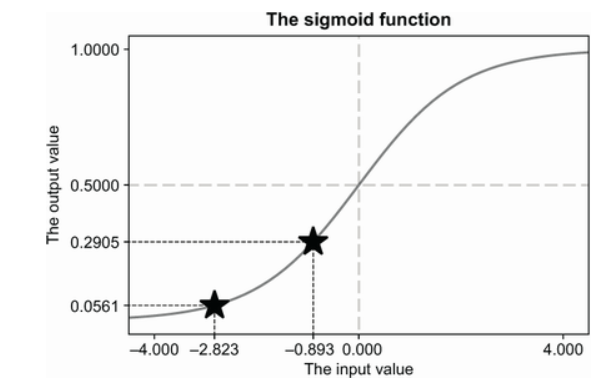

It comes clear that the second customer will more likely to stay using the service.

In [45]:
val_dict_small = df_val[subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

In [46]:
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

In [55]:
y_pred_small

array([0.38725235, 0.23836386, 0.15070016, ..., 0.12069586, 0.55016623,
       0.03389637])

## Using the Model

Apply the model to the validation set, and predict each customer the churning probability. Remember to use the same preprocessing on the validation and test set. 

In [71]:
customer = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'no',
    'dependents': 'no',
    'tenure': 41,
    'phoneservice': 'yes',
    'multiplelines': 'no',
    'internetservice': 'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year',
    'paperlessbilling': 'yes',
    'paymentmethod': 'bank_transfer_(automatic)',
    'monthlycharges': 79.85,
    'totalcharges': 3320.75,
}

In [72]:
X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.07332239057816664

Probability of this customer exit is greatly dim, only 7.3%.

Because only one customer is computed against the model, a NumPy array will return one row and two columns. Use the bracket operator to retrieve value of churning probability.

In [73]:
## Seeing feature values for this customer
print(list(X_test[0]))

[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 79.85, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 41.0, 3320.75]


In [74]:
np.dot(X_test[0], model.coef_[0].round(3))

-3.86215

In [75]:
print(1 / (1 + np.exp(3.86215)))

0.020589895711707704


Let's try it again on the second customer.

In [60]:
customer = {
    'gender': 'female',
    'seniorcitizen': 1,
    'partner': 'no',
    'dependents': 'no',
    'phoneservice': 'yes',
    'multiplelines': 'yes',
    'internetservice': 'fiber_optic',
    'onlinesecurity': 'no',
    'onlinebackup': 'no',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'yes',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 85.7,
    'totalcharges': 85.7
}


X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.8321649550627843

In [61]:
model.predict_proba(X_test)

array([[0.16783504, 0.83216496]])

This customer has around 83.2% chance of exiting, so we may persuade business unit to give him a promotional mail in hopes for retaining him.

In [69]:
np.dot(X_test[0], model.coef_[0].round(3))

1.7047

In [70]:
print(1 / (1 + np.exp(-1.7047)))

0.8461475855215457
